# Proposed model over the full dataset

The full dataset is pre-processed and predicted.

In [29]:
import keras
import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf

from keras.utils import to_categorical
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Data loading

In [ ]:
# When using Goolge Colab
from google.colab import drive
drive.mount('/content/drive')

In [6]:
base_path = "."

In [10]:
full_filepath = f"{base_path}/datasets/zenodo_open_metadata_2020-11-14_processed_text_4000.jsonl"
full_df = pd.read_json(full_filepath, lines=True)  # The file is JSONLines

In [11]:
full_df.head()

,recid,spam,text_4000
0,3900603,False,the geodynamic world builder the geodynamic wo...
1,3363990,False,alignment ambiguous characters indel maximum l...
2,3363503,False,biodiversity taxonomy animalia arthropoda inse...
3,3363619,False,biodiversity taxonomy animalia arthropoda maxi...
4,3363729,False,biodiversity taxonomy animalia arthropoda inse...


In [12]:
# Split dataset

labels = full_df['spam']
cat_labels = to_categorical(labels)
data = full_df["text_4000"]

In [13]:
full_df.head()

,recid,spam,text_4000
0,3900603,False,the geodynamic world builder the geodynamic wo...
1,3363990,False,alignment ambiguous characters indel maximum l...
2,3363503,False,biodiversity taxonomy animalia arthropoda inse...
3,3363619,False,biodiversity taxonomy animalia arthropoda maxi...
4,3363729,False,biodiversity taxonomy animalia arthropoda inse...


In [14]:
spam_ham = full_df.spam.value_counts()
print(spam_ham)

False    1684521
True       37784
Name: spam, dtype: int64


## One Hot vectorization

One hot encoding allows to have each term identified in a vocabulary, which is needed for the input of the `Embedding` layerd. In addition, TF-IDF can camuflage different words with a similar score and we want the Embedding to find this out.

In [15]:
vocab_size = 150000  # To account for different languages
max_input_length = 4000 # We assume that there cannot be more than 4000k words 

In [16]:
data_vec = []
max_length = -1
safeguard = 4000

for record in data:
    # filters and lower should not be needed. Those were applied on preprocessing (notebook 0)
    vec = one_hot(record, vocab_size, split=' ')
    vec_len = len(vec)
    if vec_len > max_length:
        max_length = vec_len

    # This should never happen, it is just a safeguard
    if vec_len > safeguard:
        if len(record.split(' ')) > safeguard:  # This should never be True. It is a safeguard.
            print(f"Hard failure. input len {len(record)}")
        print(f"Soft failure. One hot expanded, found length {vec_len}")
    
    data_vec.append(vec)
    
print(f"Maximum length {max_length}")

Soft failure. One hot expanded, found length 4053
Soft failure. One hot expanded, found length 4244
Soft failure. One hot expanded, found length 4341
Soft failure. One hot expanded, found length 4141
Soft failure. One hot expanded, found length 4149
Soft failure. One hot expanded, found length 4132
Soft failure. One hot expanded, found length 4120
Soft failure. One hot expanded, found length 4127
Soft failure. One hot expanded, found length 4539
Soft failure. One hot expanded, found length 4117
Soft failure. One hot expanded, found length 4136
Soft failure. One hot expanded, found length 4118
Soft failure. One hot expanded, found length 4141
Soft failure. One hot expanded, found length 4141
Soft failure. One hot expanded, found length 4141
Soft failure. One hot expanded, found length 4141
Soft failure. One hot expanded, found length 4362
Soft failure. One hot expanded, found length 4141
Soft failure. One hot expanded, found length 4141
Soft failure. One hot expanded, found length 4184


In [17]:
# Cannot save the padded vector cuz it weights more than 4GiB
pickle.dump(data_vec, open(f"{base_path}/vectors/zenodo_open_metadata_2020-12-13-full_text_4000_one_hot_padded.pkl","wb"))
pickle.dump(cat_labels, open(f"{base_path}/vectors/zenodo_open_metadata_2020-12-13_full_cat_labels.pkl","wb"))

In [18]:
# Execute only if needed
data_vec = pickle.load(open(f"{base_path}/vectors/zenodo_open_metadata_2020-12-13-full_text_4000_one_hot_padded.pkl","rb"))
cat_labels = pickle.load(open(f"{base_path}/vectors/zenodo_open_metadata_2020-12-13_full_cat_labels.pkl","rb"))

In [19]:
data_vec_padded = pad_sequences(data_vec, maxlen=max_length)

## Predict the full dataset

Using the chosen model (VI), saved as `models/2020_11_26_deeper_crnn`. Note that verbose shows the amount of batches (aprox num of records divided by 32).

In [62]:
model_vi = tf.keras.models.load_model(f"{base_path}/models/2020_11_21_paper_twitter_rnn")

In [ ]:
y_predclass = model_vi.predict(data_vec_padded, workers=10, verbose=True)

y_predclass = np.argmax(y_predclass, axis=1)
y = np.argmax(cat_labels, axis=1)

model_accuracy = round(accuracy_score(y, y_predclass), 3)
print(f"Train accuracy: {model_accuracy}")

print("Train Classification Report")
print(classification_report(y, y_predclass))

53773/53823 [============================>.] - ETA: 43s

In [ ]:
pickle.dump(y_predclass, open(f"{base_path}/vectors/zenodo_open_metadata_2020-11-21_y_predclass_paper_twitter_rnn.pkl","wb"))

In [44]:
def plot_conf_mat(conf_mat):
    plt.figure()
    ax = plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, cbar=False, cmap="Accent_r", fmt='g', #annot=True to annotate cells
                vmin=1500, vmax=10000) # To display properly as confusion matrix
    # YlGnBu
    # TN | FP
    #--------
    # FN | TN
    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Ham', 'Spam'])
    ax.yaxis.set_ticklabels(['Ham', 'Spam'])

In [45]:
y_predclass[-1]

0

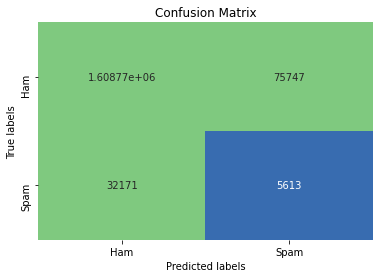

In [46]:
cm = confusion_matrix(y_pred=y_predclass, y_true=y)
plot_conf_mat(cm)